# Feature Analysis for kNN

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from knn_preprocessing import knn_preprocessing


# set random state for reproducibility
kwargs = dict(random_state=42)

In [56]:
# Load Datasets
movies = pd.read_csv('../../data/preprocessed/movies_id_updated.csv', sep=',')
actors = pd.read_csv('../../data/raw/actors.csv', sep=',')
countries = pd.read_csv('../../data/raw/countries.csv', sep=',')
directors = pd.read_csv('../../data/raw/directors.csv', sep=',')
genres = pd.read_csv('../../data/raw/genres.csv', sep=',')
locations = pd.read_csv('../../data/raw/locations.csv', sep=',')
movie_tags = pd.read_csv('../../data/raw/movie_tags.csv', sep=',')
ratings = pd.read_csv('../../data/preprocessed/ratings_clean_std_0.csv', sep=',')
tags =  pd.read_csv('../../data/raw/tags.csv', sep=',')
omdb = pd.read_csv('../../data/preprocessed/omdb_cleaned.csv')

In [57]:
omdb.columns

Index(['Title', 'Year', 'Rated', 'Runtime', 'Writer', 'Plot', 'Language',
       'imdbRating', 'imdbVotes', 'imdbID', 'Rotten Tomatoes', 'Metacritic',
       'Series', 'Released_season', 'Released_month', 'Released_day',
       'PG_Rating', 'Available_languages', 'Oscars_won', 'Oscars_nominated',
       'Golden_globe_won', 'Golden_globe_nominated'],
      dtype='object')

In [58]:
omdb = omdb[['Year','Runtime', 'Language',
       'imdbRating', 'imdbVotes', 'imdbID', 'Rotten Tomatoes', 'Metacritic',
       'Series', 'Released_season', 'Released_month', 'Released_day',
       'PG_Rating', 'Available_languages', 'Oscars_won', 'Oscars_nominated',
       'Golden_globe_won', 'Golden_globe_nominated']]

In [59]:
omdb.head()

,Year,Runtime,Language,imdbRating,imdbVotes,imdbID,Rotten Tomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated
0,1995.0,81.0,['English'],8.3,852896.0,tt0114709,10.0,9.5,0,4.0,11.0,22.0,0.0,1,0.0,3.0,0.0,0.0
1,1995.0,104.0,"['English', ' French']",7.0,294340.0,tt0113497,5.4,3.9,0,1.0,12.0,15.0,1.0,2,0.0,0.0,0.0,0.0
2,1993.0,103.0,['English'],7.0,41401.0,tt0107050,6.3,5.3,0,1.0,12.0,25.0,2.0,1,0.0,0.0,0.0,0.0
3,1995.0,124.0,['English'],5.9,9222.0,tt0114885,5.6,NaN,0,1.0,12.0,22.0,3.0,1,0.0,0.0,0.0,0.0
4,1995.0,106.0,['English'],6.0,33005.0,tt0113041,4.8,4.9,0,1.0,12.0,8.0,1.0,1,0.0,0.0,0.0,1.0


In [63]:
# Add movies which could not be retrieved by omdb

# Dropping the 10 almost empty movies
indices = omdb[omdb['imdbRating'].isna()]['imdbID'].index
for i in indices:
    omdb = omdb.drop([i], axis=0, )

# Fill NaN Runtime
omdb.loc[:, 'Runtime'] = omdb.loc[:, 'Runtime'].fillna(omdb.loc[:, 'Runtime'].median())
# Fill NaN for imdbVotes
omdb.loc[:, 'imdbVotes'] = omdb.loc[:, 'imdbVotes'].fillna(omdb.loc[:, 'imdbVotes'].median())
# for i in range (4,16):
# omdb.iloc[:,i] = omdb.iloc[:,i].fillna(omdb.iloc[:,i].median())

omdb = omdb.rename(columns={"Rotten Tomatoes": "RottenTomatoes"})

# Replace RT Score with Metacritic if NaN
# where Replace values where the condition is False.
omdb['RottenTomatoes'] = omdb['RottenTomatoes'].where(~omdb['RottenTomatoes'].isna(), omdb['Metacritic'])

# Replace Metacritic with RT Scroe if NaN
omdb['Metacritic'].where(~omdb['Metacritic'].isna(), omdb['RottenTomatoes'])

# Fill remaining with mean()
omdb['RottenTomatoes'] = omdb['RottenTomatoes'].where(~omdb['RottenTomatoes'].isna(), omdb['RottenTomatoes'].mean())
omdb['Metacritic'] = omdb['Metacritic'].where(~omdb['Metacritic'].isna(), omdb['Metacritic'].mean())

merged_data = ratings.merge(omdb, how='left', on='imdbID')
merged_data = merged_data.drop(columns={'Unnamed: 0'})

# Replace for Series, PG and awards NaN with 0 and handle accordingly
for i in ['PG_Rating', 'Available_languages', 'Oscars_won', 'Oscars_nominated',
   'Golden_globe_won', 'Golden_globe_nominated']:
    merged_data.loc[:, i] = merged_data.loc[:, i].fillna(0)

# convert imdbID from string to float
merged_data['imdbID'] = merged_data['imdbID'].str.replace(r'tt', '')
merged_data['imdbID'] = merged_data['imdbID'].astype(float)

# Jetzt einfach ma5 mean() eingefüllt
print(merged_data.columns)
for i in range(6, 16):
    merged_data.iloc[:, i] = merged_data.iloc[:, i].fillna(merged_data.iloc[:, i].median())

for i in range(15, 19):
     merged_data.iloc[:, i] = merged_data.iloc[:, i].fillna(0)


Index(['user_id', 'imdbID', 'rating', 'Year', 'Runtime', 'Language',
       'imdbRating', 'imdbVotes', 'RottenTomatoes', 'Metacritic', 'Series',
       'Released_season', 'Released_month', 'Released_day', 'PG_Rating',
       'Available_languages', 'Oscars_won', 'Oscars_nominated',
       'Golden_globe_won', 'Golden_globe_nominated'],
      dtype='object')


In [64]:
merged_data

,user_id,imdbID,rating,Year,Runtime,Language,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated
0,1264,47034.0,3.5,1954.0,96.0,['Japanese'],7.6,27485.0,9.3,7.800000,0.0,2.0,5.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0
1,213,304141.0,2.5,2004.0,142.0,['English'],7.9,524511.0,9.0,8.200000,0.0,3.0,6.0,4.0,1.0,1.0,0.0,2.0,0.0,0.0
2,593,369436.0,3.0,2008.0,88.0,['English'],5.7,61335.0,2.4,4.100000,0.0,4.0,11.0,26.0,2.0,1.0,0.0,0.0,0.0,0.0
3,609,1077258.0,4.0,2007.0,105.0,['English'],7.1,196149.0,7.4,5.780126,0.0,3.0,6.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1590,52182.0,4.0,1958.0,100.0,['English'],7.4,6337.0,6.9,5.780126,0.0,1.0,2.0,11.0,0.0,1.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787536,1032,83530.0,3.0,1982.0,85.0,['English'],6.2,47327.0,4.2,4.800000,0.0,1.0,12.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0
787537,99,107798.0,3.0,1993.0,141.0,['English'],6.6,73544.0,5.3,5.000000,0.0,1.0,12.0,17.0,2.0,1.0,0.0,0.0,0.0,0.0
787538,333,93857.0,3.0,1987.0,88.0,"['English', ' Spanish']",5.1,12882.0,0.7,2.800000,0.0,3.0,7.0,10.0,2.0,2.0,0.0,0.0,0.0,0.0
787539,49,144168.0,3.0,1999.0,94.0,['English'],6.1,17926.0,7.1,6.500000,0.0,3.0,8.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0


In [69]:
merged_data['Awards'] = merged_data['Oscars_won']+merged_data['Golden_globe_won']+merged_data['Oscars_nominated']+merged_data['Golden_globe_nominated']

In [71]:
merged_data.describe()

,user_id,imdbID,rating,Year,Runtime,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated,Awards
count,787541.000000,7.875410e+05,787541.000000,787272.000000,787272.000000,787541.000000,7.875410e+05,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000
mean,692.828912,1.854573e+05,3.438227,1992.360846,114.032130,7.119191,2.369228e+05,7.088473,6.438238,0.002995,2.506875,6.799881,15.868155,2.030359,1.765803,0.481409,0.481287,0.004578,0.066619,1.033892
std,499.428706,1.479920e+05,1.002999,14.389344,24.279886,0.931680,3.175175e+05,2.401364,1.666967,0.054648,1.102796,3.424577,8.461036,1.034206,1.201183,1.264556,1.115085,0.075813,0.321370,1.533121
min,0.000000,4.390000e+02,0.500000,1903.000000,5.000000,1.500000,1.900000e+01,0.000000,0.100000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,274.000000,9.515900e+04,3.000000,1988.000000,98.000000,6.600000,4.243300e+04,5.600000,5.600000,0.000000,1.000000,4.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,595.000000,1.186550e+05,3.500000,1997.000000,110.000000,7.200000,1.197590e+05,7.800000,6.400000,0.000000,3.000000,7.000000,16.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1045.000000,2.653070e+05,4.000000,2002.000000,126.000000,7.800000,2.874750e+05,9.000000,7.600000,0.000000,3.000000,10.000000,23.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2112.000000,1.349938e+06,5.000000,2010.000000,608.000000,9.400000,2.238077e+06,10.000000,10.000000,1.000000,4.000000,12.000000,31.000000,4.000000,13.000000,9.000000,9.000000,5.000000,4.000000,9.000000


In [72]:
merged_data = merged_data.drop(columns={'Oscars_won', 'Oscars_nominated',
       'Golden_globe_won', 'Golden_globe_nominated'})

In [75]:
merged_data.dtypes

user_id                  int64
imdbID                 float64
rating                 float64
Year                   float64
Runtime                float64
Language                object
imdbRating             float64
imdbVotes              float64
RottenTomatoes         float64
Metacritic             float64
Series                 float64
Released_season        float64
Released_month         float64
Released_day           float64
PG_Rating              float64
Available_languages    float64
Awards                 float64
dtype: object

In [76]:
merged_data['Language'] = merged_data['Language'].replace(0, 'None')

In [77]:
merged_data

,user_id,imdbID,rating,Year,Runtime,Language,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Awards
0,1264,47034.0,3.5,1954.0,96.0,['Japanese'],7.6,27485.0,9.3,7.800000,0.0,2.0,5.0,7.0,0.0,1.0,0.0
1,213,304141.0,2.5,2004.0,142.0,['English'],7.9,524511.0,9.0,8.200000,0.0,3.0,6.0,4.0,1.0,1.0,2.0
2,593,369436.0,3.0,2008.0,88.0,['English'],5.7,61335.0,2.4,4.100000,0.0,4.0,11.0,26.0,2.0,1.0,0.0
3,609,1077258.0,4.0,2007.0,105.0,['English'],7.1,196149.0,7.4,5.780126,0.0,3.0,6.0,13.0,0.0,1.0,0.0
4,1590,52182.0,4.0,1958.0,100.0,['English'],7.4,6337.0,6.9,5.780126,0.0,1.0,2.0,11.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787536,1032,83530.0,3.0,1982.0,85.0,['English'],6.2,47327.0,4.2,4.800000,0.0,1.0,12.0,10.0,1.0,1.0,0.0
787537,99,107798.0,3.0,1993.0,141.0,['English'],6.6,73544.0,5.3,5.000000,0.0,1.0,12.0,17.0,2.0,1.0,0.0
787538,333,93857.0,3.0,1987.0,88.0,"['English', ' Spanish']",5.1,12882.0,0.7,2.800000,0.0,3.0,7.0,10.0,2.0,2.0,0.0
787539,49,144168.0,3.0,1999.0,94.0,['English'],6.1,17926.0,7.1,6.500000,0.0,3.0,8.0,4.0,2.0,1.0,0.0


In [78]:
#mlb = preprocessing.MultiLabelBinarizer()

In [ ]:
#mlb.fit_transform(merged_data['Language'])

In [80]:
merged_data=merged_data.drop(columns={'Language'})

In [81]:
user_sample = merged_data.loc[merged_data['user_id'] == 123]

In [82]:
user_sample

,user_id,imdbID,rating,Year,Runtime,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Awards
2700,123,107688.0,5.0,1993.0,76.0,8.0,282449.0,9.5,8.2,0.0,4.0,10.0,29.0,1.0,1.0,1.0
20972,123,319061.0,4.0,2003.0,125.0,8.0,404894.0,7.5,5.8,0.0,1.0,1.0,9.0,2.0,2.0,1.0
51933,123,118715.0,5.0,1998.0,117.0,8.1,702389.0,8.2,7.1,0.0,2.0,3.0,6.0,3.0,4.0,0.0
69225,123,119822.0,3.5,1997.0,139.0,7.7,267139.0,8.5,6.7,0.0,1.0,12.0,25.0,2.0,1.0,2.0
91942,123,338135.0,5.0,2003.0,99.0,7.6,27600.0,8.2,7.0,0.0,2.0,3.0,5.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742419,123,248845.0,5.0,2001.0,95.0,7.7,30873.0,9.2,8.5,0.0,3.0,8.0,31.0,3.0,2.0,1.0
745967,123,112281.0,1.5,1995.0,90.0,6.4,196970.0,3.1,4.5,0.0,4.0,11.0,10.0,2.0,1.0,0.0
768099,123,108052.0,5.0,1993.0,195.0,8.9,1165580.0,9.7,9.4,0.0,1.0,2.0,4.0,3.0,5.0,7.0
779240,123,181875.0,5.0,2000.0,122.0,7.9,243109.0,8.9,9.0,0.0,4.0,9.0,22.0,3.0,2.0,1.0


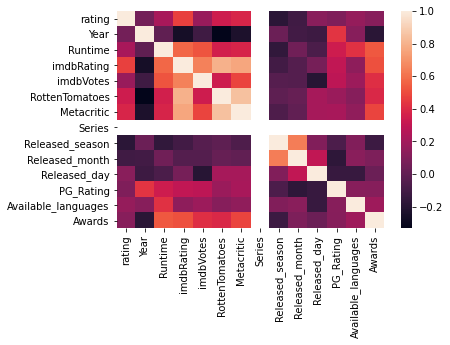

In [105]:
sns.heatmap(user_sample.drop(columns={'user_id','imdbID'}).corr(method='pearson'))

In [102]:
user_sample.drop(columns={'user_id','imdbID'}).corr(method='pearson')

,rating,Year,Runtime,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Awards
rating,1.000000,0.061173,0.221143,0.471888,0.173426,0.343165,0.381473,NaN,-0.178574,-0.106282,0.128565,0.095792,0.161347,0.124280
Year,0.061173,1.000000,-0.000832,-0.260858,-0.112943,-0.334058,-0.233702,NaN,0.035551,-0.101592,-0.119137,0.432950,0.121041,-0.184717
Runtime,0.221143,-0.000832,1.000000,0.574719,0.521021,0.355547,0.378345,NaN,-0.161488,0.047099,-0.070202,0.339673,0.421905,0.535527
imdbRating,0.471888,-0.260858,0.574719,1.000000,0.650004,0.799686,0.763755,NaN,-0.104692,-0.041310,0.069859,0.297367,0.142935,0.513979
imdbVotes,0.173426,-0.112943,0.521021,0.650004,1.000000,0.343060,0.481738,NaN,-0.033742,-0.037746,-0.196571,0.290987,0.185114,0.415867
RottenTomatoes,0.343165,-0.334058,0.355547,0.799686,0.343060,1.000000,0.851098,NaN,-0.007744,0.017812,0.213430,0.177713,0.114662,0.390922
Metacritic,0.381473,-0.233702,0.378345,0.763755,0.481738,0.851098,1.000000,NaN,-0.058348,0.003350,0.216202,0.218882,0.148646,0.483032
Series,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Released_season,-0.178574,0.035551,-0.161488,-0.104692,-0.033742,-0.007744,-0.058348,NaN,1.000000,0.636800,0.098500,-0.066230,0.098703,-0.125146
Released_month,-0.106282,-0.101592,0.047099,-0.041310,-0.037746,0.017812,0.003350,NaN,0.636800,1.000000,0.297860,-0.168143,0.126766,0.090856


In [103]:
user_sample.drop(columns={'user_id','imdbID'}).corr(method='kendall')

,rating,Year,Runtime,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Awards
rating,1.000000,0.024144,0.144485,0.348846,0.057472,0.210312,0.284408,NaN,-0.052491,-0.033659,0.059019,0.210228,0.168138,0.085262
Year,0.024144,1.000000,-0.002690,-0.160747,-0.124181,-0.262976,-0.116195,NaN,-0.034128,-0.191197,-0.162273,0.269084,0.072817,-0.131658
Runtime,0.144485,-0.002690,1.000000,0.380463,0.276274,0.211350,0.219460,NaN,-0.119865,-0.018445,-0.036766,0.294257,0.345507,0.345141
imdbRating,0.348846,-0.160747,0.380463,1.000000,0.501211,0.633106,0.583388,NaN,-0.111377,-0.085235,0.022769,0.290566,0.155484,0.441371
imdbVotes,0.057472,-0.124181,0.276274,0.501211,1.000000,0.284588,0.335926,NaN,-0.019310,-0.022051,-0.174211,0.219461,0.114390,0.378588
RottenTomatoes,0.210312,-0.262976,0.211350,0.633106,0.284588,1.000000,0.708828,NaN,-0.043104,-0.050101,0.127654,0.160327,0.149268,0.366539
Metacritic,0.284408,-0.116195,0.219460,0.583388,0.335926,0.708828,1.000000,NaN,-0.030740,0.012043,0.143217,0.250767,0.216969,0.434489
Series,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Released_season,-0.052491,-0.034128,-0.119865,-0.111377,-0.019310,-0.043104,-0.030740,NaN,1.000000,0.610500,0.071875,-0.062727,0.021767,-0.136952
Released_month,-0.033659,-0.191197,-0.018445,-0.085235,-0.022051,-0.050101,0.012043,NaN,0.610500,1.000000,0.227192,-0.153113,0.042637,0.048471


In [83]:
#perform principal components analysis on training set
pca = PCA(**kwargs)
pca.fit(user_sample.drop(columns={'user_id','imdbID','rating'}))
pca.explained_variance_ratio_.round(8)

array([0.99999999, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [87]:
pca_score = pca.explained_variance_ratio_

In [88]:
print(pca_score)

[9.99999993e-01 4.74856963e-09 1.70520440e-09 5.26403065e-10
 1.07089318e-10 3.54142101e-11 1.64246162e-11 1.46101588e-11
 5.97325737e-12 5.33160086e-12 3.15058135e-12 8.65790872e-13
 3.71773800e-45]


In [89]:
from sklearn.linear_model import LogisticRegression

In [97]:
user_sample['rating'].apply(lambda x: 2*x).astype(int)

2700      10
20972      8
51933     10
69225      7
91942     10
          ..
742419    10
745967     3
768099    10
779240    10
780940    10
Name: rating, Length: 68, dtype: int64

In [98]:
log = LogisticRegression().fit(user_sample.drop(columns={'user_id','imdbID','rating'}), user_sample['rating'].apply(lambda x: 2*x).astype(int))

/Users/FlorianGrabe/.local/share/virtualenvs/bda-analytics-challenge-ss2020-5N-4F0V3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
log.fit(user_sample.drop(columns={'user_id','imdbID','rating'}), user_sample['rating'])

In [159]:
# Restricted to X Rows currently for faster calculations (r)
merged_movies = merged_movies.iloc[:100000]

X = np.array(merged_movies.iloc[:,0:11])

y = np.array(merged_movies['rating'])

In [160]:
# Checking Array dimensions
print(X.shape)
print(y.shape)

(100000, 11)
(100000,)


In [161]:
# Preprocess Data: Remove all Strings
le = preprocessing.LabelEncoder()
for i in range(0,11):
    X[:,i] = le.fit_transform(X[:,i])

In [162]:
y = le.fit_transform(y)

In [163]:
# split into training and test set
#TODO Split Data in Three and optimize for validation set to compare rmse and accuracy for Validation and Test Set!

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5, **kwargs)


In [164]:
# Define Classifier 
#Adjust k neighbors value according to dataset 
#May take a while depending on how large the dataset is chosen above -> r
optimal_k = find_optimal_k()
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=-1)

Tested Classifier until k=10
Tested Classifier until k=20
Tested Classifier until k=30
Tested Classifier until k=40
Tested Classifier until k=50
Tested Classifier until k=60
Tested Classifier until k=70
Tested Classifier until k=80
Tested Classifier until k=90
Tested Classifier until k=100
Tested Classifier until k=110
Tested Classifier until k=120
Tested Classifier until k=130
Tested Classifier until k=140
Tested Classifier until k=150
Tested Classifier until k=160
Tested Classifier until k=170
Tested Classifier until k=180
Tested Classifier until k=190
Optmial k: 3


In [165]:
#training Classifier
print("Training")
knn.fit(X_train, y_train)

Training


KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [166]:
# Do predictions
print("Do Prediction")
pred = knn.predict(X_test)

Do Prediction


In [167]:
# Check Accuracy
print("Accuracy : {}".format(accuracy_score(y_test, pred)))
#RMSE for ratings [0,5]
print("RMSE : {}".format(mean_squared_error(y_test, pred, squared=False)))

Accuracy : 0.60805
RMSE : 1.7691240770505612


In [158]:
#Improve Algorithm and find good k to choose
#Limit data set to X rows for finding optimal k
#!Only execute this cell for full dataset with time and computational power!

#Lets save time for now
limited_movies = merged_movies.iloc[:100000]

X = np.array(limited_movies.iloc[:,0:5])

y = np.array(limited_movies['rating'])

def find_optimal_k():
    k_acc_scores = []
    accuracy = 0
    
    for k in range(1, 200):
        if k % 10 == 0 :
            print("Tested Classifier until k="+str(k))
        
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)
        k_acc_scores.append("k({}) = Accuracy: {} RMSE: {} ".format(k, accuracy_score(y_test, pred), mean_squared_error(y_test, pred, squared=False)))
        
        if (accuracy_score(y_test, pred) > accuracy):
            optimal_k = k
            accuracy = accuracy_score(y_test, pred)
   
    #For full info
    #print(k_acc_scores)
    
    print("Optmial k: "+str(optimal_k)+"with accuracy: "+str(accuracy))
    return optimal_k

In [144]:
#Drop NaN rows - check later if it makes large difference!
omdb=omdb.dropna()

# Dimensionality Reduction

In [168]:
#perform principal components analysis on training set
pca = PCA(**kwargs)
pca.fit(X_train)
pca.explained_variance_ratio_.round(8)

array([9.9938421e-01, 3.9600000e-04, 2.0314000e-04, 1.6650000e-05,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00])

In [ ]:
X_train_trans = pca.transform(X_train)[:, :2]
X_test_trans = pca.transform(X_test)[:, :2]

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
print("Training")
knn.fit(X_train_trans, y_train)
print("Do Prediction")
pred = knn.predict(X_test_trans)
# Check Accuracy
print("Accuracy : {}".format(accuracy_score(y_test, pred)))
#RMSE for ratings [0,5]
print("RMSE : {}".format(mean_squared_error(y_test, pred, squared=False)))

In [ ]:
#Ansatzidee: 
#1 Seperate labeled and unlabeled data
#2 Use SVM and SSL to train and improve  

In [169]:
#Ansatzidee: 
#1 Seperate labeled and unlabeled data
#2 Use SVM and SSL to train and improve  

In [170]:
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
print("Training")
knn.fit(X_train_trans, y_train)
print("Do Prediction")
pred = knn.predict(X_test_trans)
# Check Accuracy
print("Accuracy : {}".format(accuracy_score(y_test, pred)))
#RMSE for ratings [0,5]
print("RMSE : {}".format(mean_squared_error(y_test, pred, squared=False)))

Training
Do Prediction
Accuracy : 0.9942
RMSE : 0.20506096654409878
